In [1]:
import time
from unityagents import UnityEnvironment
import numpy as np
import torch
import random
from agent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name='Env_20_Agents/Reacher_Linux/Reacher.x86_64', no_graphics = True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
#reset the environment
env_info = env.reset(train_mode=True)[brain_name]

#number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

#size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

#examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
#definition hyperparameters and trainingsconditions
n_episodes = 300
max_noice= 1.0
noice_decay = 0.995
training_mode = True
random_seed = 0

Episode:0 Score:0.7724999827332795 Mean Score(last 100 episodes):0.7724999827332795 Duration episode:03m50s Duration training:00h03m50s
Episode:1 Score:1.370499969366938 Mean Score(last 100 episodes):1.0714999760501087 Duration episode:03m55s Duration training:00h07m46s
Episode:2 Score:2.7554999384097756 Mean Score(last 100 episodes):1.6328332968366643 Duration episode:03m56s Duration training:00h11m42s
Episode:3 Score:5.225499883200973 Mean Score(last 100 episodes):2.5309999434277417 Duration episode:03m54s Duration training:00h15m37s
Episode:4 Score:9.229999793693423 Mean Score(last 100 episodes):3.870799913480878 Duration episode:03m55s Duration training:00h19m32s
Episode:5 Score:12.464999721385539 Mean Score(last 100 episodes):5.303166548131655 Duration episode:03m58s Duration training:00h23m31s
Episode:6 Score:16.52199963070452 Mean Score(last 100 episodes):6.905856988499207 Duration episode:03m58s Duration training:00h27m29s
Episode:7 Score:19.03949957443401 Mean Score(last 100 e

Episode:54 Score:38.48449913980439 Mean Score(last 100 episodes):31.38096293494444 Duration episode:05m38s Duration training:04h16m49s
Environment solved in 54 episodes. Mean score over all 20 agents 31.38096293494444 for the last 100 episodes
Episode:55 Score:38.784999133087695 Mean Score(last 100 episodes):31.51317786705414 Duration episode:05m43s Duration training:04h22m33s
Environment solved in 55 episodes. Mean score over all 20 agents 31.51317786705414 for the last 100 episodes
Episode:56 Score:38.68849913524464 Mean Score(last 100 episodes):31.63906069632064 Duration episode:05m39s Duration training:04h28m12s
Environment solved in 56 episodes. Mean score over all 20 agents 31.63906069632064 for the last 100 episodes
Episode:57 Score:38.045999149605635 Mean Score(last 100 episodes):31.74952515241176 Duration episode:06m05s Duration training:04h34m17s
Environment solved in 57 episodes. Mean score over all 20 agents 31.74952515241176 for the last 100 episodes
Episode:58 Score:38.29

Episode:88 Score:36.46699918489903 Mean Score(last 100 episodes):33.77191497547594 Duration episode:05m58s Duration training:07h37m06s
Environment solved in 88 episodes. Mean score over all 20 agents 33.77191497547594 for the last 100 episodes
Episode:89 Score:35.32599921040237 Mean Score(last 100 episodes):33.78918257808623 Duration episode:05m58s Duration training:07h43m04s
Environment solved in 89 episodes. Mean score over all 20 agents 33.78918257808623 for the last 100 episodes
Episode:90 Score:36.944499174226074 Mean Score(last 100 episodes):33.82385638683502 Duration episode:05m57s Duration training:07h49m02s
Environment solved in 90 episodes. Mean score over all 20 agents 33.82385638683502 for the last 100 episodes
Episode:91 Score:37.795499155204745 Mean Score(last 100 episodes):33.867026416925995 Duration episode:06m10s Duration training:07h55m12s
Environment solved in 91 episodes. Mean score over all 20 agents 33.867026416925995 for the last 100 episodes
Episode:92 Score:38.

Episode:122 Score:35.56149920513853 Mean Score(last 100 episodes):37.67664415786136 Duration episode:06m00s Duration training:11h01m57s
Environment solved in 122 episodes. Mean score over all 20 agents 37.67664415786136 for the last 100 episodes
Episode:123 Score:38.10099914837629 Mean Score(last 100 episodes):37.70757915716991 Duration episode:06m02s Duration training:11h07m59s
Environment solved in 123 episodes. Mean score over all 20 agents 37.70757915716991 for the last 100 episodes
Episode:124 Score:38.01049915039912 Mean Score(last 100 episodes):37.732004156623965 Duration episode:06m02s Duration training:11h14m02s
Environment solved in 124 episodes. Mean score over all 20 agents 37.732004156623965 for the last 100 episodes
Episode:125 Score:36.80049917744473 Mean Score(last 100 episodes):37.75310415615235 Duration episode:06m01s Duration training:11h20m03s
Environment solved in 125 episodes. Mean score over all 20 agents 37.75310415615235 for the last 100 episodes
Episode:126 Sc

Episode:156 Score:37.166499169263986 Mean Score(last 100 episodes):37.60298415950779 Duration episode:06m00s Duration training:14h27m40s
Environment solved in 156 episodes. Mean score over all 20 agents 37.60298415950779 for the last 100 episodes
Episode:157 Score:37.90549915274605 Mean Score(last 100 episodes):37.60157915953919 Duration episode:06m00s Duration training:14h33m40s
Environment solved in 157 episodes. Mean score over all 20 agents 37.60157915953919 for the last 100 episodes
Episode:158 Score:38.767999133467676 Mean Score(last 100 episodes):37.606284159434026 Duration episode:06m09s Duration training:14h39m50s
Environment solved in 158 episodes. Mean score over all 20 agents 37.606284159434026 for the last 100 episodes
Episode:159 Score:38.300499143917115 Mean Score(last 100 episodes):37.608654159381054 Duration episode:06m00s Duration training:14h45m50s
Environment solved in 159 episodes. Mean score over all 20 agents 37.608654159381054 for the last 100 episodes
Episode:1

Episode:190 Score:37.952999151684345 Mean Score(last 100 episodes):37.75445915612206 Duration episode:06m04s Duration training:17h53m33s
Environment solved in 190 episodes. Mean score over all 20 agents 37.75445915612206 for the last 100 episodes
Episode:191 Score:38.08249914878979 Mean Score(last 100 episodes):37.75732915605791 Duration episode:06m01s Duration training:17h59m35s
Environment solved in 191 episodes. Mean score over all 20 agents 37.75732915605791 for the last 100 episodes
Episode:192 Score:38.15799914710224 Mean Score(last 100 episodes):37.75506415610854 Duration episode:06m01s Duration training:18h05m36s
Environment solved in 192 episodes. Mean score over all 20 agents 37.75506415610854 for the last 100 episodes
Episode:193 Score:37.31049916604534 Mean Score(last 100 episodes):37.75309915615246 Duration episode:06m11s Duration training:18h11m48s
Environment solved in 193 episodes. Mean score over all 20 agents 37.75309915615246 for the last 100 episodes
Episode:194 Sco

Episode:224 Score:38.71599913462997 Mean Score(last 100 episodes):37.79566915520094 Duration episode:05m58s Duration training:21h18m53s
Environment solved in 224 episodes. Mean score over all 20 agents 37.79566915520094 for the last 100 episodes
Episode:225 Score:38.88149913093075 Mean Score(last 100 episodes):37.8164791547358 Duration episode:06m07s Duration training:21h25m00s
Environment solved in 225 episodes. Mean score over all 20 agents 37.8164791547358 for the last 100 episodes
Episode:226 Score:38.31199914366007 Mean Score(last 100 episodes):37.8137191547975 Duration episode:06m01s Duration training:21h31m01s
Environment solved in 226 episodes. Mean score over all 20 agents 37.8137191547975 for the last 100 episodes
Episode:227 Score:37.106999170593916 Mean Score(last 100 episodes):37.79903915512562 Duration episode:06m01s Duration training:21h37m03s
Environment solved in 227 episodes. Mean score over all 20 agents 37.79903915512562 for the last 100 episodes
Episode:228 Score:3

Episode:258 Score:37.699999157339334 Mean Score(last 100 episodes):37.98088415106106 Duration episode:06m03s Duration training:00h45m08s
Environment solved in 258 episodes. Mean score over all 20 agents 37.98088415106106 for the last 100 episodes
Episode:259 Score:37.94849915178493 Mean Score(last 100 episodes):37.977364151139746 Duration episode:06m02s Duration training:00h51m10s
Environment solved in 259 episodes. Mean score over all 20 agents 37.977364151139746 for the last 100 episodes
Episode:260 Score:37.95899915155023 Mean Score(last 100 episodes):37.97575415117573 Duration episode:06m10s Duration training:00h57m21s
Environment solved in 260 episodes. Mean score over all 20 agents 37.97575415117573 for the last 100 episodes
Episode:261 Score:36.949499174114315 Mean Score(last 100 episodes):37.96136415149737 Duration episode:06m03s Duration training:01h03m24s
Environment solved in 261 episodes. Mean score over all 20 agents 37.96136415149737 for the last 100 episodes
Episode:262 

Episode:292 Score:38.90049913050607 Mean Score(last 100 episodes):38.062344149240296 Duration episode:06m12s Duration training:04h14m15s
Environment solved in 292 episodes. Mean score over all 20 agents 38.062344149240296 for the last 100 episodes
Episode:293 Score:38.363999142497775 Mean Score(last 100 episodes):38.07287914900482 Duration episode:06m11s Duration training:04h20m27s
Environment solved in 293 episodes. Mean score over all 20 agents 38.07287914900482 for the last 100 episodes
Episode:294 Score:38.58449913756922 Mean Score(last 100 episodes):38.08639414870273 Duration episode:06m13s Duration training:04h26m40s
Environment solved in 294 episodes. Mean score over all 20 agents 38.08639414870273 for the last 100 episodes
Episode:295 Score:38.96099912915379 Mean Score(last 100 episodes):38.100159148395065 Duration episode:06m10s Duration training:04h32m51s
Environment solved in 295 episodes. Mean score over all 20 agents 38.100159148395065 for the last 100 episodes
Episode:296

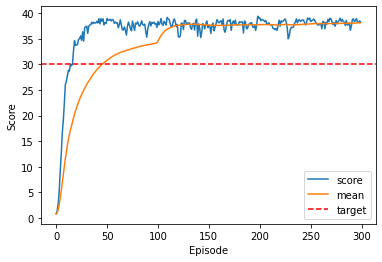

In [6]:
#Initialize Feed-forward DNNs for Actor and Critic models. 
agent = Agent(state_size, action_size, random_seed, max_noice, noice_decay)

#train the agent
def ddpg_train(n_episodes):
    #list containing scores from each episode
    scores = []
    #list containing means over last 100 episodes
    means = []
    #last 100 scores
    scores_window = deque(maxlen = 100)
    # messure time for achieving a mean score over 30
    start_time = time.time()
    for episode in range(n_episodes):
        # messure time for one episode
        start_episode = time.time()
        # Reset the enviroment
        env_info = env.reset(train_mode=training_mode)[brain_name] 
        cur_states = env_info.vector_observations
        score = np.zeros(num_agents)
        # initialize timestep
        timestep = 0
        # reset noise
        agent.reset()
        while True:
            # Choose best action for given network
            actions = agent.act(cur_states, add_noise = True)
            # Action is performed and new state, reward, info are received. 
            env_info = env.step(actions)[brain_name]
            # get next state 
            next_states = env_info.vector_observations
            # see if episode is finished
            dones = env_info.local_done
            # get reward
            rewards = env_info.rewards
            # save experience to replay buffer, perform learning step at defined interval"
            for cur_state, action, reward, next_state, done in zip(cur_states, 
                                                                   actions, 
                                                                   rewards, 
                                                                   next_states, 
                                                                   dones):
                # current state, action, reward, new state are stored in the experience replay"
                agent.step(cur_state, action, reward, next_state, done, timestep)
            # roll over new state
            cur_states = next_states      
            #add reward to score
            score += rewards
            # count timestep
            timestep+=1
            
            if np.any(dones):
                break
        
        #calculate time
        time_episode = time.time() - start_episode
        time_entire = time.time() - start_time
        #save most recent score
        scores_window.append(score)
        scores.append(score)
        mean = np.mean(scores_window)
        means.append(mean)
        print("Episode:" + str(episode) + " Score:" + str(np.mean(score)) + 
              " Mean Score(last 100 episodes):" + str(np.mean(scores_window)) +
              " Duration episode:" + time.strftime('%Mm%Ss', time.gmtime(time_episode)) + 
              " Duration training:" + time.strftime('%Hh%Mm%Ss', time.gmtime(time_entire)))
        
        #save model weights
        if (episode+1) % 10 == 0 or np.mean(scores_window) >= 30:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_Actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_Critic.pth')
            if np.mean(scores_window) >= 30:
                print("Environment solved in " + str(episode) + " episodes. Mean score over all 20 agents " +
                      str(np.mean(scores_window)) + " for the last 100 episodes")
    
    return scores, means

scores, means = ddpg_train(n_episodes)

episode_scores = []
for record in scores:
    episode_scores.append(np.mean(record))

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_scores)), episode_scores, label = "score")
plt.plot(np.arange(len(means)), means, label = "mean")
plt.axhline(y=30, color='r', linestyle='--', label="target")
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

In [7]:
env.close()